Optiver D1 Assessment - Nick James

The Python notebook below provides exploratory data analysis (EDA), sequential hypothesis testing, strategy exploration and discussion. All of the points below are addressed at various points in this notebook, however, should I have the opportunity to present these findings to another QR, I will be able to highlight specific details in my choice of various experiments/models/etc. <br>

These experiments only demonstrate a sample of the (more successful) work that I have done. In addition to this, I have implemented a variety of machine learning-oriented experiments which do not appear to be profitable both in and out of training data. I'd be more than happy to discuss these findings, also. <br>

$\textbf{Dataset Exploration}$ <br>
You have been provided data for 2 different financial instruments over a 1-year period, top level bid ask price and volume <br>
1 - Explore the dataset and present the findings (e.g. anomalies, correlations, periodic patterns)  <br>
$\textbf{Pricing Relationships}$ <br>
1 - Identify potential pricing signals based on the relationships/patterns discovered in the previous step  <br>
2 - Develop and test whether these signals are a good predictor of future  <br>
$\textbf{Trading Strategy}$ <br>
Based on your findings above, describe how you would monetise the opportunity. <br>
1 - Describe metrics you can use to measure performance of the strategy <br>
2 - Plot the profit of your trading strategy over time <br>
3 - Highlight limitations of the signals and strategy <br>
4 - Provide potential areas for further research <br>

We will start by reading in the data and our required packages. We have subsequently discovered that the last trading day is incomplete so we will remove it from our analysis

In [1]:
# Read in packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from scipy.signal import savgol_filter
import datetime
from scipy.fftpack import fft, fftshift
from sklearn.linear_model import LinearRegression
import itertools

In [2]:
# Read in the data
df = pd.read_csv(r"C:\Users\60848\Desktop\opt\final_data_10s.csv", index_col='Time', parse_dates=True)
# 30th December 2020 as last day of trading due to incomplete data on last day
df = df.loc['2019-11-18':'2020-12-30'] 

In [3]:
# Potential separation of training data and testing data for formal separation of train/test sets experiments
model = "All"
make_plots = True # Turn plots on/off

if model == "Train":
    df = df.loc['2019-11-18':'2020-08-30']
if model == "Test":
    df = df.loc['2020-08-31':'2020-12-30']
if model == "All":
    df = df.loc['2019-11-18':'2020-12-30']

In [4]:
# Append X_spread and Y_spread
df["X_Spread"] = df["X_ASK"] - df["X_BID"]
df["Y_Spread"] = df["Y_ASK"] - df["Y_BID"]

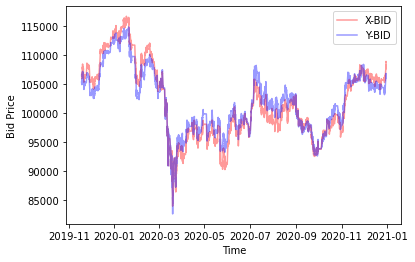

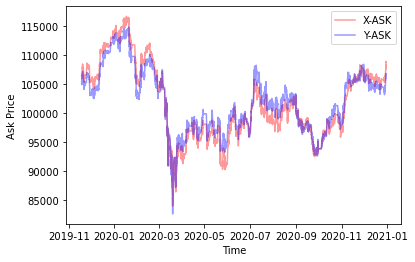

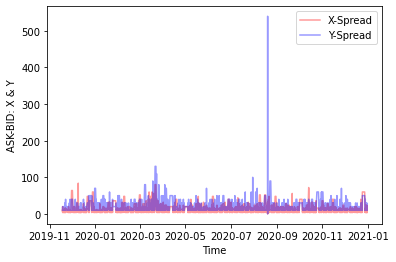

In [5]:
if make_plots:
    # Plot the two time series w.r.t their evolution over time
    plt.plot(df.index, df["X_BID"], color='red', alpha = 0.4, label="X-BID")
    plt.plot(df.index, df["Y_BID"], color='blue', alpha = 0.4, label="Y-BID")
    plt.xlabel("Time")
    plt.ylabel("Bid Price")
    plt.legend()
    plt.savefig("Opt_Bid_TS_"+model)
    plt.show()

    # Plot the two time series
    plt.plot(df.index, df["X_ASK"], color='red', alpha = 0.4, label="X-ASK")
    plt.plot(df.index, df["Y_ASK"], color='blue', alpha = 0.4, label="Y-ASK")
    plt.xlabel("Time")
    plt.ylabel("Ask Price")
    plt.legend()
    plt.savefig("Opt_Ask_TS_"+model)
    plt.show()

    # Plot the two time series
    plt.plot(df.index, df["X_Spread"], alpha = 0.4, color='red', label="X-Spread")
    plt.plot(df.index, df["Y_Spread"], alpha = 0.4, color='blue', label="Y-Spread")
    plt.xlabel("Time")
    plt.ylabel("ASK-BID: X & Y")
    plt.legend()
    plt.savefig("Opt_XY_Liquidity_"+model)
    plt.show()

In [6]:
# Compute Log returns of Securities X & Y and create new columns
# Note - we are treating the securities as a continuous signal from day-to-day
df['X_BID_log_returns'] = np.log(df["X_BID"]) - np.log(df["X_BID"].shift(1))
df['Y_BID_log_returns'] = np.log(df["Y_BID"]) - np.log(df["Y_BID"].shift(1))
df['X_ASK_log_returns'] = np.log(df["X_ASK"]) - np.log(df["X_ASK"].shift(1))
df['Y_ASK_log_returns'] = np.log(df["Y_ASK"]) - np.log(df["Y_ASK"].shift(1))

In this section we explore spectral analysis of the securities. We wish to see if there are any notable periodic components that are persistent within the securities, meaningfully different between securities, etc. To do so, we compute the $ \textit{log periodogram}$, which requires computing the $\textit{Discrete Fourier Transform}$ of a demeaned time series and then studying its squared modulus

In [7]:
# Demean Time Series
x_returns = np.nan_to_num(df["X_BID_log_returns"])
y_returns = np.nan_to_num(df["Y_BID_log_returns"])
x_returns_demean = x_returns - np.mean(x_returns)
y_returns_demean = y_returns - np.mean(y_returns)

# Compute log periodogram - Note we remove the first frequency component and only explore the first half of the function due to anti-symmetry
log_periodogram_x = np.log(np.abs((fft(fftshift(x_returns_demean)))**2))[1:len(y_returns_demean)//2]
log_periodogram_y = np.log(np.abs((fft(fftshift(y_returns_demean)))**2))[1:len(y_returns_demean)//2]

# Parameters for smoothing
window_size = (6 * 60 * 8) + 1 # Current smoothing corresponds to an 8 hour window (approximately a one-day trading window of smoothing)
polynomial_order = 2
X_spectrum_smooth = np.nan_to_num(savgol_filter(log_periodogram_x, window_size, polynomial_order))
Y_spectrum_smooth = np.nan_to_num(savgol_filter(log_periodogram_y, window_size, polynomial_order))

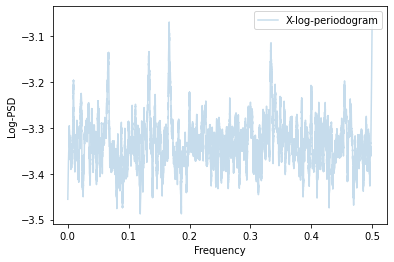

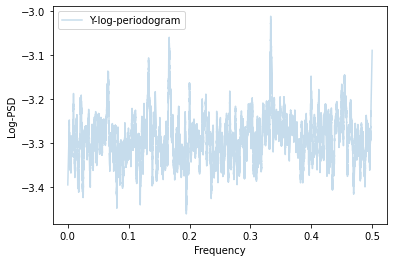

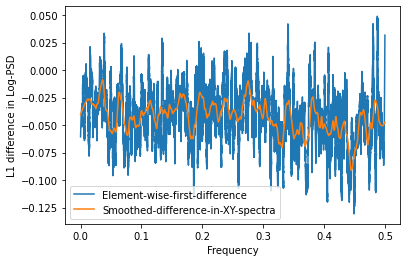

In [8]:
if make_plots:
    # Plot power spectrum - X
    plt.plot(np.linspace(0, 0.5, (len(log_periodogram_x))), X_spectrum_smooth, label="X-log-periodogram", alpha=0.25)
    plt.xlabel("Frequency")
    plt.ylabel("Log-PSD")
    plt.legend()
    plt.savefig("opt_securities_power_spectrum_X_"+model)
    plt.show()

    # Plot power spectrum - Y
    plt.plot(np.linspace(0, 0.5, (len(log_periodogram_y))), Y_spectrum_smooth, label="Y-log-periodogram", alpha=0.25)
    plt.xlabel("Frequency")
    plt.ylabel("Log-PSD")
    plt.savefig("opt_securities_power_spectrum_Y_"+model)
    plt.legend()
    plt.show()

    # Plot element-wise difference - is there any trend here?
    plt.plot(np.linspace(0, 0.5, len(X_spectrum_smooth)), X_spectrum_smooth - Y_spectrum_smooth, label="Element-wise-first-difference")
    plt.plot(np.linspace(0, 0.5, len(X_spectrum_smooth)), savgol_filter((X_spectrum_smooth - Y_spectrum_smooth), 15001, 2), label="Smoothed-difference-in-XY-spectra")
    plt.xlabel("Frequency")
    plt.ylabel("L1 difference in Log-PSD")
    plt.legend()
    plt.savefig("Opt_securities_power_spectrum_difference_"+model)
    plt.show()

There are notable periodic components at frequencies $\sim \nu = \{0.06 0.12, 0.15, 0.33\}$. Notable power at these frequency components may indicate periodic cycles of 1 week and a bi-weekly cycle. Of course, given the smoothing we have applied, we may be looking at a signal which is excessively smoothed and erroneous periodic cycles.  

In [9]:
# Confirm strong correlation throughout our window of analysis
correlation_bid = df["X_BID_log_returns"].corr(df["Y_BID_log_returns"])
correlation_ask = df["X_ASK_log_returns"].corr(df["Y_ASK_log_returns"])

# Print correlations
print("Correlation bid ", correlation_bid)
print("Correlation ask ", correlation_ask)

Correlation bid  0.9513355795825095
Correlation ask  0.95218962905671


The correlation between the two securities is indeed high - but how does this association evolve over time? Are there points throughout the day where this changes? To explore this, we will $\textit{analyze the day in expectation and on varying timescales.}$ It is possible that mispricings only occur on specific timescales

In [10]:
# Add additional features for minute, hour, day, week, month, year
df["Date"] = df.index.date
df["Second"] = df.index.second
df["Minute"] = df.index.minute
df["Hour"] = df.index.hour
df["Day"] = df.index.day
df["Week"] = df.index.week
df["Month"] = df.index.month
df["Year"] = df.index.year

# Write a function to generate a table over the space which may identify dislocations
def dislocation_function(df, grid_periodicity):
    
    # Loop over all grid components and assess divergence in correlation and other metrics
    grid = np.linspace(np.min(df[grid_periodicity]), np.max(df[grid_periodicity]), len(np.unique(df[grid_periodicity])))
    metrics_periodicity_list = []
    for i in range(len(grid)):
        slice = df.loc[df[grid_periodicity] == grid[i]]
        bid_correlation = slice["X_BID_log_returns"].corr(slice["Y_BID_log_returns"])
        ask_correlation = slice["X_ASK_log_returns"].corr(slice["Y_ASK_log_returns"])
        x_bid_liquidity = slice["X_BID_VOL"].mean()
        x_ask_liquidity = slice["X_ASK_VOL"].mean()
        y_bid_liquidity = slice["X_BID_VOL"].mean()
        y_ask_liquidity = slice["X_ASK_VOL"].mean()

        X_spread = slice["X_Spread"].mean()
        Y_spread = slice["Y_Spread"].mean()
        x_returns_mean = slice["X_BID_log_returns"].mean()
        x_returns_sd = slice["X_BID_log_returns"].std()
        y_returns_mean = slice["Y_BID_log_returns"].mean()
        y_returns_sd = slice["Y_BID_log_returns"].std()
        returns_mean_diff = x_returns_mean - y_returns_mean
        metrics_periodicity_list.append([grid[i], bid_correlation, ask_correlation, x_bid_liquidity, x_ask_liquidity,
                                         y_bid_liquidity, y_ask_liquidity, X_spread, Y_spread, x_returns_mean,
                                         y_returns_mean, x_returns_sd, y_returns_sd, returns_mean_diff])

    # Correlation scores minute array
    metrics_periodicity_df = pd.DataFrame(metrics_periodicity_list)
    metrics_periodicity_df.columns = ["Periodicity", "Bid_correlation", "Ask_correlation", "X_Bid_liquidity", "X_Ask_liquidity",
                                      "Y_Bid_liquidity", "Y_Ask_liquidity", "X_Spread", "Y_Spread", "X_log_returns",
                                     "Y_log_returns", "X_standard_deviation", "Y_standard_deviation", "Returns_mean_difference"]
    return metrics_periodicity_df

# Generate dislocation grid
dislocation_minute_grid = dislocation_function(df, "Minute")
dislocation_hour_grid = dislocation_function(df, "Hour")
dislocation_day_grid = dislocation_function(df, "Day")
dislocation_week_grid = dislocation_function(df, "Week")
dislocation_month_grid = dislocation_function(df, "Month")
dislocation_year_grid = dislocation_function(df, "Year")

C:\Users\60848\AppData\Local\Temp/ipykernel_98176/3618397770.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["Week"] = df.index.week


In [11]:
# Print dislocation minute/hour/day grid, etc.
# print(dislocation_minute_grid)
print(dislocation_hour_grid)

   Periodicity  Bid_correlation  Ask_correlation  X_Bid_liquidity  \
0          8.0         0.967595         0.967671         4.767366   
1          9.0         0.898667         0.899045         4.979924   
2         10.0         0.135027         0.266920         4.364303   
3         11.0         0.912021         0.919629         4.990118   
4         12.0         0.898986         0.899470         5.035276   
5         13.0         0.880366         0.880930         5.082512   
6         14.0         0.889126         0.895700         4.819071   

   X_Ask_liquidity  Y_Bid_liquidity  Y_Ask_liquidity   X_Spread   Y_Spread  \
0         3.382308         4.767366         3.382308  14.300435  20.366544   
1         3.592733         4.979924         3.592733  14.218691  20.209658   
2         2.792176         4.364303         2.792176  19.784841  30.195599   
3         3.588441         4.990118         3.588441  14.465010  20.502785   
4         3.644703         5.035276         3.644703  14.

We can identify a clear structural break (based on steady state dynamics) at 10am. One can see the following: <br>
1 - An obvious break in correlation structure at 10am <br>
2 - An order of magnitude change in difference of average log returns between X and Y <br>
3 - Huge jump in spreads for both X and Y, indicating less liquidity and difficulty in executing strategies <br>

We now wish to study this evolution at a finer level of granularity. We wish to study a "typical day" in expectation, and explore the average evolution by 10 second increments. To do so, we will loop over all possible second/minute/hour triples, and compute expected values, variances, etc.

In [12]:
date_unique = df["Date"].unique()
hour_unique = df["Hour"].unique()
minute_unique = df["Minute"].unique()
second_unique = df["Second"].unique()

# Hour/minute grid
hour_spacing = np.linspace(np.min(hour_unique), np.max(hour_unique), len(hour_unique))
minute_spacing = np.linspace(np.min(minute_unique), np.max(minute_unique), len(minute_unique))
second_spacing = np.arange(0,60,10)

# Data in each minute/hour increment
minute_hour_second_returns_list = []
for i in range(len(hour_spacing)):
    for j in range(len(minute_spacing)):
        for k in range(len(second_spacing)):
            unique_minute_hour = df.loc[(df["Minute"]==minute_spacing[j]) & (df["Hour"]==hour_spacing[i]) & (df["Second"]==second_spacing[k])]
            correlation_bid_xy = np.nan_to_num(unique_minute_hour["X_BID_log_returns"].corr(unique_minute_hour["Y_BID_log_returns"]))
            x_spread = unique_minute_hour["X_Spread"].mean()
            y_spread = unique_minute_hour["Y_Spread"].mean()
            x_bid_avg_returns = unique_minute_hour["X_BID_log_returns"].mean()
            y_bid_avg_returns = unique_minute_hour["Y_BID_log_returns"].mean()
            x_ask_avg_returns = unique_minute_hour["X_ASK_log_returns"].mean()
            y_ask_avg_returns = unique_minute_hour["Y_ASK_log_returns"].mean()
            # Log returns mispricing
            x_y_avg_mispricing_returns = np.abs(x_ask_avg_returns - y_ask_avg_returns) 
            # Absolute difference in average BID price
            x_y_avg_mispricing_price = unique_minute_hour["X_BID"].mean() - unique_minute_hour["Y_BID"].mean()
            x_bid_liquidity = unique_minute_hour["X_BID_VOL"].mean()
            x_ask_liquidity = unique_minute_hour["X_ASK_VOL"].mean()
            y_bid_liquidity = unique_minute_hour["Y_BID_VOL"].mean()
            y_ask_liquidity = unique_minute_hour["Y_ASK_VOL"].mean()
            if unique_minute_hour["X_BID"].mean() > unique_minute_hour["Y_BID"].mean():
                state = "X_greater"
            if unique_minute_hour["X_BID"].mean() == unique_minute_hour["Y_BID"].mean():
                state = "neutral"
            if unique_minute_hour["X_BID"].mean() < unique_minute_hour["Y_BID"].mean():
                state = "Y_greater"
            minute_hour_second_returns_list.append([hour_spacing[i], minute_spacing[j], second_spacing[k], len(unique_minute_hour), correlation_bid_xy,
                                             x_spread, y_spread, x_bid_avg_returns, y_bid_avg_returns, x_ask_avg_returns, y_ask_avg_returns, x_y_avg_mispricing_returns, x_y_avg_mispricing_price, state,
                                             x_bid_liquidity, x_ask_liquidity, y_bid_liquidity, y_ask_liquidity])
    print("Hour iteration ", i)
# Convert to Dataframe
minute_hour_second_df = pd.DataFrame(minute_hour_second_returns_list)
minute_hour_second_df.columns = ["Hour", "Minute", "Second",  "Samples", "Correlation", "X_avg_spread", "Y_avg_spread", "X_bid_avg_returns", "Y_bid_avg_returns", 
                                 "X_ask_avg_returns", "Y_ask_avg_returns", "X_Y_avg_mispricing_returns", "X_Y_avg_mispricing_price", "State",
                          "x_bid_liquidity", "x_ask_liquidity", "y_bid_liquidity", "y_ask_liquidity"]

# Print out minute-hour-second dataframe
print(minute_hour_second_df)

Hour iteration  0
Hour iteration  1
Hour iteration  2
Hour iteration  3
Hour iteration  4
Hour iteration  5
Hour iteration  6
      Hour  Minute  Second  Samples  Correlation  X_avg_spread  Y_avg_spread  \
0      8.0     0.0       0      409     0.974146     14.503667     20.562347   
1      8.0     0.0      10      409     0.955757     14.484108     20.562347   
2      8.0     0.0      20      409     0.920342     14.396088     20.171149   
3      8.0     0.0      30      409     0.928958     14.415648     20.440098   
4      8.0     0.0      40      409     0.939478     14.454768     20.293399   
...    ...     ...     ...      ...          ...           ...           ...   
2515  14.0    59.0      10        0     0.000000           NaN           NaN   
2516  14.0    59.0      20        0     0.000000           NaN           NaN   
2517  14.0    59.0      30        0     0.000000           NaN           NaN   
2518  14.0    59.0      40        0     0.000000           NaN           N

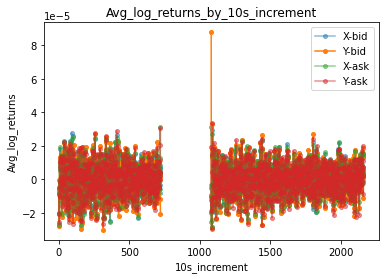

In [13]:
# Remove the first 10 second increment for 8:00:00 and plot the others
plt.plot(minute_hour_second_df["X_bid_avg_returns"][1:], alpha = 0.5, label="X-bid", marker='o', linestyle='-', markersize=4)
plt.plot(minute_hour_second_df["Y_bid_avg_returns"][1:], alpha = 1, label="Y-bid", marker='o', linestyle='-', markersize=4)
plt.plot(minute_hour_second_df["X_ask_avg_returns"][1:], alpha = 0.5, label="X-ask", marker='o', linestyle='-', markersize=4)
plt.plot(minute_hour_second_df["Y_ask_avg_returns"][1:], alpha = 0.5, label="Y-ask", marker='o', linestyle='-', markersize=4)
plt.title("Avg_log_returns_by_10s_increment")
plt.ylabel("Avg_log_returns")
plt.xlabel("10s_increment")
plt.legend()
plt.show()

If we look at the evolution of average log returns throughout the day, it is clear that at 11am, Y-BID is materially overpriced relative to its typical behaviour. This implies that we should be SELLING Y at around 11am.

In [14]:
# Sort by Price mispricing in descending order
mhs_divergence_small = minute_hour_second_df.sort_values(by="X_Y_avg_mispricing_price", ascending=False)
print(mhs_divergence_small)

      Hour  Minute  Second  Samples  Correlation  X_avg_spread  Y_avg_spread  \
2160  14.0     0.0       0      409     0.889126     14.141809     19.731051   
2159  13.0    59.0      50      409     0.843646     14.259169     19.682152   
2143  13.0    57.0      10      409     0.880223     14.092910     19.217604   
2144  13.0    57.0      20      409     0.793053     14.024450     19.486553   
2142  13.0    57.0       0      409     0.845190     14.083130     19.559902   
...    ...     ...     ...      ...          ...           ...           ...   
2515  14.0    59.0      10        0     0.000000           NaN           NaN   
2516  14.0    59.0      20        0     0.000000           NaN           NaN   
2517  14.0    59.0      30        0     0.000000           NaN           NaN   
2518  14.0    59.0      40        0     0.000000           NaN           NaN   
2519  14.0    59.0      50        0     0.000000           NaN           NaN   

      X_bid_avg_returns  Y_bid_avg_retu

Key insights when ranked by descending order: <br>
1 - Y is always higher than X (in expectation) <br>
2 -14:00:0, 13:59:50 and 13:57:0 are key points where we see smallest divergence <br>
3 - Note that the bid-ask spreads do not seem totally excessive at these times <br>

In [15]:
# Sort by Price mispricing in descending order
mhs_divergence_large = minute_hour_second_df.sort_values(by="X_Y_avg_mispricing_price", ascending=True)
print(mhs_divergence_large)

      Hour  Minute  Second  Samples  Correlation  X_avg_spread  Y_avg_spread  \
1105  11.0     4.0      10      409     0.889173     14.875306     20.537897   
1104  11.0     4.0       0      409     0.943081     14.630807     20.855746   
1103  11.0     3.0      50      409     0.905537     14.493888     20.733496   
1102  11.0     3.0      40      409     0.869667     14.709046     20.806846   
1108  11.0     4.0      40      409     0.915903     14.562347     20.537897   
...    ...     ...     ...      ...          ...           ...           ...   
2515  14.0    59.0      10        0     0.000000           NaN           NaN   
2516  14.0    59.0      20        0     0.000000           NaN           NaN   
2517  14.0    59.0      30        0     0.000000           NaN           NaN   
2518  14.0    59.0      40        0     0.000000           NaN           NaN   
2519  14.0    59.0      50        0     0.000000           NaN           NaN   

      X_bid_avg_returns  Y_bid_avg_retu

Key insights when ranked by descending order:  <br>
1 - Y is always higher than X (in expectation) <br>
2 - 11:04:10, 11:04:0, 11:03:50, 11:03:40 appear to be points in time where we see largest divergence <br>
3 - All of these instances appear to offer reasonable bid-ask spreads (liquidity). <br>

$\textbf{Strategy 1: Naive intra-day pricing exploitation}$ <br>

We appear to find a larger divergence between the asset prices' average value (intra-day) around 11am than we do around 2pm. Perhaps, we could build an intra-day trading strategy by trying to optimise the times we go long the X/Y trade and close the position out, within any candidate trading day. We will loop over a range of possible times to open a position and a range of times to potentially close out the position. 

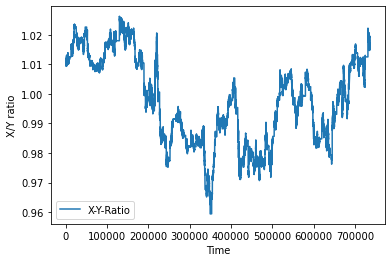

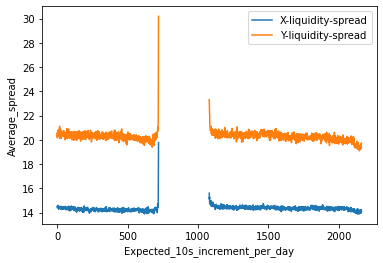

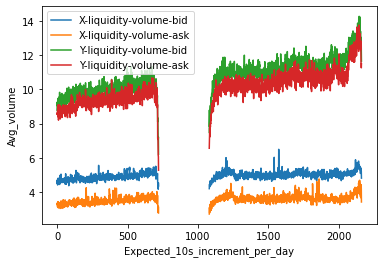

In [16]:
if make_plots:
    # Plot Ratio of one time series to the other (this is meant to be stationary)
    plt.plot(np.nan_to_num(df["X_BID"]/df["Y_BID"]), label="X-Y-Ratio")
    plt.ylabel("X/Y ratio")
    plt.xlabel("Time")
    plt.legend()
    plt.savefig("X_Y_Ratio_"+model)
    plt.show()

    # Liquidity Throughout the day (bid-ask spread)
    plt.plot(minute_hour_second_df["X_avg_spread"], label="X-liquidity-spread")
    plt.plot(minute_hour_second_df["Y_avg_spread"], label="Y-liquidity-spread")
    plt.xlabel("Expected_10s_increment_per_day")
    plt.ylabel("Average_spread")
    plt.legend()
    plt.savefig("Opt_Liquidity_over_time_"+model)
    plt.show()

    # Liquidity Throughout the day (bid-ask spread)
    plt.plot(minute_hour_second_df["x_bid_liquidity"], label = "X-liquidity-volume-bid")
    plt.plot(minute_hour_second_df["x_ask_liquidity"], label = "X-liquidity-volume-ask")
    plt.plot(minute_hour_second_df["y_bid_liquidity"], label = "Y-liquidity-volume-bid")
    plt.plot(minute_hour_second_df["y_ask_liquidity"], label = "Y-liquidity-volume-ask")
    plt.xlabel("Expected_10s_increment_per_day")
    plt.ylabel("Avg_volume")
    plt.legend()
    plt.savefig("Opt_liquidity_volume_"+model)
    plt.show()

In [17]:
# Engineer Price Names etc
price_cols = ['X_BID', 'X_ASK', 'Y_BID', 'Y_ASK']  # names the price columns
spread_df = df[['X_Spread', 'Y_Spread']].copy()
price_df = df[price_cols].copy()
log_returns = np.log(df[price_cols]).diff()  # computes the log returns

log_returns['Time_of_Day'] = log_returns.index.time  # creates a new col with just the time of day
spread_df['Time_of_Day'] = spread_df.index.time  # creates a new col with just the time of day
price_df['Time_of_Day'] = price_df.index.time  # creates a new col with just the time of day

log_returns['Time_of_Day'] = pd.to_datetime(log_returns['Time_of_Day'], format='%H:%M:%S').dt.time #converts to time
spread_df['Time_of_Day'] = pd.to_datetime(spread_df['Time_of_Day'], format='%H:%M:%S').dt.time #converts to time
price_df['Time_of_Day'] = pd.to_datetime(price_df['Time_of_Day'], format='%H:%M:%S').dt.time #converts to time

In [18]:
# Optimise buy/sell times on Training data
# We will go LONG X SHORT Y when the divergence is LARGE and CLOSE OUT position when divergence is SMALL
# training_window = ['2019-11-18':'2020-08-30']

# Open and Close times
open_times = mhs_divergence_large[["Hour", "Minute", "Second"]].iloc[0:5]
close_times = mhs_divergence_small[["Hour", "Minute", "Second"]].iloc[0:5]
spread_limit = [10,12,14,16,18,20,22,24]

strategy_profit_list = []
cumulative_profit_training_curve = []
for i in range(len(open_times)):
    for j in range(len(close_times)):
        for k in range(len(spread_limit)):

            # Close out position
            close_time = datetime.time(np.int(close_times.iloc[j][0]), np.int(close_times.iloc[j][1]), np.int(close_times.iloc[j][2]))
            close_slice = df.loc[df.index.time==close_time] # pd.to_datetime('13:55:00').time()
            close_slice.index = close_slice.index.date

            # Open position
            open_time = datetime.time(np.int(open_times.iloc[i][0]), np.int(open_times.iloc[i][1]), np.int(open_times.iloc[i][2]))
            open_slice = df.loc[(df.index.time==open_time) & (spread_df.X_Spread < spread_limit[k]) & (spread_df.Y_Spread < spread_limit[k])] # pd.to_datetime('08:11:00').time()
            open_slice.index = open_slice.index.date
            
            # At Open (around 8:10), go long X and short Y, and close later in the day (around 155).
            strategy = close_slice.X_BID + open_slice.Y_BID - open_slice.X_ASK - close_slice.Y_ASK
            strategy.index = pd.to_datetime(strategy.index)
        
            # Contract liquidity
            contract_close_x_bid_volume = close_slice["X_BID_VOL"].mean()
            contract_open_y_bid_volume = open_slice["Y_BID_VOL"].mean()
            contract_open_x_ask_volume = open_slice["X_ASK_VOL"].mean()
            contract_close_y_ask_volume = close_slice["Y_ASK_VOL"].mean()
            
            # Cumulative Strategy training profit
            strategy_training_profit_total = strategy['2019-11-18':'2020-08-30'].sum()
            
            # Active Trading days
            print("Training_period_length ", len(strategy['2019-11-18':'2020-08-30']) )
            active_trading_days = len(strategy['2019-11-18':'2020-08-30']) - strategy.isna().sum()
            
            # Append all parameters of model
            strategy_profit_list.append([open_times.iloc[i][0], open_times.iloc[i][1], open_times.iloc[i][2], 
                                         close_times.iloc[j][0], close_times.iloc[j][1], close_times.iloc[j][2], 
                                         spread_limit[k], contract_close_x_bid_volume, contract_open_y_bid_volume,
                                         contract_open_x_ask_volume, contract_close_y_ask_volume, active_trading_days,
                                         strategy_training_profit_total])

            # Print open and close times
            print("Optimise open iteration ", i)
            print("Optimise close iteration ", j)
            print("Optimise spread iteration ", k)
            print("Strategy training profit ", strategy_training_profit_total)

C:\Users\60848\AppData\Local\Temp/ipykernel_98176/3722215184.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  close_time = datetime.time(np.int(close_times.iloc[j][0]), np.int(close_times.iloc[j][1]), np.int(close_times.iloc[j][2]))
C:\Users\60848\AppData\Local\Temp/ipykernel_98176/3722215184.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32`

Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  0
Strategy training profit  700.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  1
Strategy training profit  1848.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  2
Strategy training profit  1890.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  3
Strategy training profit  1890.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  4
Strategy training profit  1890.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  5
Strategy training profit  1890.0
Training_period_length  287
Optimise open iteration  0
Optimise close iteration  0
Optimise spread iteration  6
Strategy training p

Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  1
Strategy training profit  332.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  2
Strategy training profit  -64.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  3
Strategy training profit  -64.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  4
Strategy training profit  -64.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  5
Strategy training profit  -64.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  6
Strategy training profit  2080.0
Training_period_length  287
Optimise open iteration  1
Optimise close iteration  2
Optimise spread iteration  7
Strategy training profi

Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  2
Strategy training profit  2368.0
Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  3
Strategy training profit  2368.0
Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  4
Strategy training profit  2380.0
Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  5
Strategy training profit  2380.0
Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  6
Strategy training profit  1416.0
Training_period_length  287
Optimise open iteration  2
Optimise close iteration  4
Optimise spread iteration  7
Strategy training profit  1416.0
Training_period_length  287
Optimise open iteration  3
Optimise close iteration  0
Optimise spread iteration  0
Strategy training 

Training_period_length  287
Optimise open iteration  4
Optimise close iteration  1
Optimise spread iteration  3
Strategy training profit  1634.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  1
Optimise spread iteration  4
Strategy training profit  1634.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  1
Optimise spread iteration  5
Strategy training profit  1634.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  1
Optimise spread iteration  6
Strategy training profit  1790.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  1
Optimise spread iteration  7
Strategy training profit  1790.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  2
Optimise spread iteration  0
Strategy training profit  740.0
Training_period_length  287
Optimise open iteration  4
Optimise close iteration  2
Optimise spread iteration  1
Strategy training p

In [19]:
# Strategy profit dataframe
strategy_profit_train_df = pd.DataFrame(strategy_profit_list)
strategy_profit_train_df.columns = ["Open_Hour", "Open_Minute", "Open_10s_increment", "Close_Hour", 
                                    "Close_Minute", "Close_10s_increment", "Spread", 
                                   "X_BID_VOLUME", "Y_BID_VOLUME", "X_ASK_VOLUME", "Y_ASK_VOLUME", "Active_trading_days",
                                    "Train_profit"]
strategy_train_profit_sort = strategy_profit_train_df.sort_values(by="Train_profit", ascending=False)

In [20]:
print(strategy_train_profit_sort)

     Open_Hour  Open_Minute  Open_10s_increment  Close_Hour  Close_Minute  \
156       11.0          3.0                40.0        13.0          57.0   
157       11.0          3.0                40.0        13.0          57.0   
140       11.0          3.0                40.0        13.0          57.0   
141       11.0          3.0                40.0        13.0          57.0   
148       11.0          3.0                40.0        13.0          57.0   
..         ...          ...                 ...         ...           ...   
50        11.0          4.0                 0.0        13.0          59.0   
45        11.0          4.0                 0.0        14.0           0.0   
44        11.0          4.0                 0.0        14.0           0.0   
42        11.0          4.0                 0.0        14.0           0.0   
43        11.0          4.0                 0.0        14.0           0.0   

     Close_10s_increment  Spread  X_BID_VOLUME  Y_BID_VOLUME  X_ASK_VOLUME 

C:\Users\60848\AppData\Local\Temp/ipykernel_98176/692612647.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  close_time = datetime.time(np.int(opt_close_hour), np.int(opt_close_minute), np.int(opt_close_second))
C:\Users\60848\AppData\Local\Temp/ipykernel_98176/692612647.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precis

Strategy Test profit  2158.0


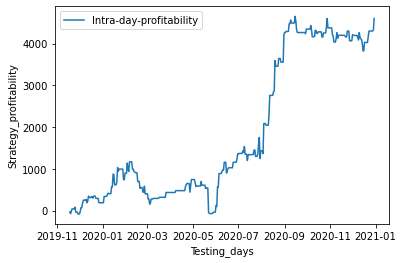

Optimal open hour 11.0
Optimal open minute 3.0
Optimal open second 40.0
Optimal close hour 13.0
Optimal close minute 57.0
Optimal close second 0.0
Optimal spread 18


In [21]:
# Gather optimal parameters for Test Data
opt_open_hour = strategy_train_profit_sort["Open_Hour"].iloc[0]
opt_open_minute = strategy_train_profit_sort["Open_Minute"].iloc[0]
opt_open_second = strategy_train_profit_sort["Open_10s_increment"].iloc[0]
opt_close_hour = strategy_train_profit_sort["Close_Hour"].iloc[0]
opt_close_minute = strategy_train_profit_sort["Close_Minute"].iloc[0]
opt_close_second = strategy_train_profit_sort["Close_10s_increment"].iloc[0]
opt_spread = strategy_train_profit_sort["Spread"].iloc[0]

# Close out position
close_time = datetime.time(np.int(opt_close_hour), np.int(opt_close_minute), np.int(opt_close_second))
close_slice = df.loc[df.index.time==close_time] 
close_slice.index = close_slice.index.date

# Open position
open_time = datetime.time(np.int(opt_open_hour), np.int(opt_open_minute), np.int(opt_open_second))
open_slice = df.loc[(df.index.time==open_time) & (spread_df.X_Spread < opt_spread) & (spread_df.Y_Spread < opt_spread)] # pd.to_datetime('08:11:00').time()
open_slice.index = open_slice.index.date

# At Open (around 8:10), go long X and short Y, and close later in the day (around 155).
strategy = close_slice.X_BID + open_slice.Y_BID - open_slice.X_ASK - close_slice.Y_ASK
strategy.index = pd.to_datetime(strategy.index)

# Cumulative Strategy training profit
strategy_test_profit_total = strategy['2020-08-31':'2020-12-30'].sum()
cumulative_profit = strategy.fillna(0).cumsum()

# Print open and close times
print("Strategy Test profit ", strategy_training_profit_total)

# Plot of strategy profit
plt.plot(cumulative_profit, label="Intra-day-profitability")
plt.xlabel("Testing_days")
plt.ylabel("Strategy_profitability")
plt.legend()
plt.savefig("Opt_strategy_profit_test")
plt.show()

# Print optimal parameters
print("Optimal open hour", opt_open_hour)
print("Optimal open minute", opt_open_minute)
print("Optimal open second", opt_open_second)
print("Optimal close hour",opt_close_hour)
print("Optimal close minute", opt_close_minute)
print("Optimal close second", opt_close_second)
print("Optimal spread", opt_spread)

$\textbf{Strategy 2: Optimised* intra-day strategy synopsis:}$

Our strategy makes money in and out of sample. There appears to be sufficient liquidity to execute upon the strategy. We have been judicious in only executing when we have tight spreads, as spread explosion eats away so much profitability. The next thing to explore would be how big a position we could take and be confident that we can close the position out. The figures above demonstrate that the least liquid component of our trading strategy is X-ask, where we can be reasonably confident (in expectation) that we can execute $\sim 3-4$ contracts at any point in time. Given that our X-ask quote would be at the beginning of the trade, advice to any candidate trader would be to purchase opportunistically and try to secure either 3 or 4 contracts - based on whatever is available in any 10 second increment. Given that there is only 3 or 4 contracts available at any point in time, one may severely impact the bid-ask spread and associated market microstructure if a trader was to purchase too aggressively. I would defer to a trader who has expertise trading the securities, but in expectation one could comfortably buy/sell 3-4 contracts in any candidate 10 second increment. Another metric that is worth observing is the # active days traded. Some of the securities have very high N/A counts, implying that under certain parameter mixes mispricing opportunities are rare - and it would be difficult to build a large profit pool as trading would be too infrequent. Fortunately, this does not appear to be the case with our most profitable strategy.

$\textbf{Strategy 3: Inter-day trading}$

It is clear that there is mispricing between securities X and Y on an intra-day basis. It is possible that mispricings may persist on longer-term timescales also. That is, we will study the evolutionary ratio of X/Y and identify points in time where this ratio breaks outside 1 standard deviation of typical bounds. Since we have identified the points in time (intra-day) where the largest mispricing occur, we will use this knowledge to inform our optimal inter-day trading strategy. A critical component of this strategy is the implementation of the try/except line - where we always try to execute at the best possible price every day. If we cannot execute at these times, we assume that we can execute at the average bid/ask on X and Y for any candidate day.

In [22]:
print(df.head())

                        X_BID  X_BID_VOL     X_ASK  X_ASK_VOL     Y_BID  \
Time                                                                      
2019-11-18 08:00:00  106340.0       15.0  106348.0       11.0  105200.0   
2019-11-18 08:00:10  106312.0        6.0  106320.0        9.0  105180.0   
2019-11-18 08:00:20  106312.0        7.0  106320.0       12.0  105170.0   
2019-11-18 08:00:30  106336.0       22.0  106340.0        1.0  105190.0   
2019-11-18 08:00:40  106352.0        2.0  106356.0        4.0  105200.0   

                     Y_BID_VOL     Y_ASK  Y_ASK_VOL  X_Spread  Y_Spread  ...  \
Time                                                                     ...   
2019-11-18 08:00:00        9.0  105210.0       19.0       8.0      10.0  ...   
2019-11-18 08:00:10        5.0  105190.0       13.0       8.0      10.0  ...   
2019-11-18 08:00:20       32.0  105180.0        1.0       8.0      10.0  ...   
2019-11-18 08:00:30       10.0  105200.0       19.0       4.0      10.0  .

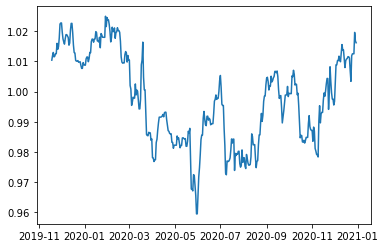

In [23]:
# Group dataframe
df_grouped = df.groupby("Date").mean()

# Plot Ratio of X-BID:Y-BID
ratio_xy = df_grouped["X_BID"]/df_grouped["Y_BID"]
plt.plot(ratio_xy)
plt.show()

def zscore(series):
    return (series - series.mean()) / np.std(series)

# Compute Z scores
z_scores = zscore(ratio_xy)

S1 = df_grouped["X_BID"]
S2 = df_grouped["Y_BID"]
ratios = S1 / S2
z_scores = z_scores

# Generate unique date grid
date_grid_unique = df["Date"].unique()

In [24]:
# We only wish to optimize the buy/sell decisions. We have already optimized the execution time and spread limits in our intra-day analysis
# We use this information to help inform our optimal decision making

def backtest(ratios, long_strategy_limit, short_strategy_limit, exit_decision):
    # Simulate trading
    curr_money = 0
    money_list = [0]
    m2m_list = []
    iterations = len(ratios)
    state = "neutral" # neutral, long_X, short_X
    state_list = ["neutral", "neutral"] # Cold start
    z_scores_long_x = []
    z_scores_short_x = []
    long_x_decision = []
    short_x_decision = []
    exit_long_x_decision = []
    exit_short_x_decision = []
    strategy_profit = []
    long_counter = 0
    short_counter = 0
    long_counter_list = []
    short_counter_list = []

    for i in range(iterations):
        print(state)
        print("Iteration", i)
        print("Z-score is", z_scores[i])

        # Long and Close dataframes
        long_slice = df.loc[(df["Date"]==date_grid_unique[i]) & (df["Hour"]==11) & (df["Minute"]==3) & (df["Second"]==40)]
        close_slice = df.loc[(df["Date"]==date_grid_unique[i]) & (df["Hour"]==13) & (df["Minute"]==57) & (df["Second"]==0)]
        optimal_spread_parameter = 18

     # Sell short if the z-score is > 1
        if state == "neutral":
            if (z_scores[i] < long_strategy_limit):  # go long on X and short on Y
                try:
                    curr_money += long_slice["Y_BID"][i] - long_slice["X_ASK"][i]
                except:
                    curr_money += df_grouped["Y_BID"][i] - df_grouped["X_ASK"][i]

                state = "long_X"
                long_x_decision.append(i)
                long_counter += 1
                state_list.append(state)
            if (z_scores[i] > short_strategy_limit):  # go long on Y and short on X
                try:
                    curr_money += close_slice["X_BID"][i] - close_slice["Y_ASK"][i]
                except:
                    curr_money += df_grouped["X_BID"][i] - df_grouped["Y_ASK"][i]
                state = "short_X"
                short_x_decision.append(i)
                short_counter += 1
                state_list.append(state)
            if state_list[-2] == "neutral" and state_list[-1] != "neutral":
                print("transition")
                state_list.pop()
            else:
                money_list.append(curr_money)
                long_counter_list.append(long_counter)
                short_counter_list.append(short_counter)
                state_list.append(state)
        if state == "long_X":
            if (z_scores[i] > exit_decision) :  # close out position, ie sell X, buy Y
                try:
                    curr_money += close_slice["X_BID"][i] - close_slice["Y_ASK"][i]
                except:
                    curr_money += df_grouped["X_BID"][i] - df_grouped["Y_ASK"][i]
                state = "neutral"
                exit_long_x_decision.append(i)
                long_counter -= 1
            money_list.append(curr_money)
            long_counter_list.append(long_counter)
            short_counter_list.append(short_counter)
            state_list.append(state)
        if state == "short_X":
            if (z_scores[i] < exit_decision):  # Close out position, ie sell Y, buy X
                try:
                    curr_money += long_slice["Y_BID"][i] - long_slice["X_ASK"][i]
                except:
                    curr_money += df_grouped["Y_BID"][i] - df_grouped["X_ASK"][i]
                state = "neutral"
                exit_short_x_decision.append(i)
                short_counter -= 1
            money_list.append(curr_money)
            long_counter_list.append(long_counter)
            short_counter_list.append(short_counter)
            state_list.append(state)

        ### THESE LINES OF CODE ALLOW YOU TO CLOSE OUT THE STRATEGY AT TERMINAL POINT (IF NECESSARY) ###

        if (state == "short_X") and (i == (iterations-1)):
            print("Close out at terminal point")
            try:
                curr_money += long_slice["Y_BID"][i] - long_slice["X_ASK"][i]
            except:
                curr_money += df_grouped["Y_BID"][i] - df_grouped["X_ASK"][i]
            state = "neutral"
            exit_short_x_decision.append(i-1)
            short_counter -= 1
            money_list.append(curr_money)
            long_counter_list.append(long_counter)
            short_counter_list.append(short_counter)
            state_list.append(state)
        if (state == "long_X") and (i == (iterations-1)):
            print("Close out at terminal point")
            try:
                curr_money += close_slice["X_BID"][i] - close_slice["Y_ASK"][i]
            except:
                curr_money += df_grouped["X_BID"][i] - df_grouped["Y_ASK"][i]
            state = "neutral"
            exit_long_x_decision.append(i-1)
            long_counter -= 1
            money_list.append(curr_money)
            long_counter_list.append(long_counter)
            short_counter_list.append(short_counter)
            state_list.append(state)
    
        # Fix state list for cold start problem
        state_list_cs_fix = state_list[2:]
        money_list_cs_fix = money_list[1:]
    
    return money_list_cs_fix, state_list_cs_fix, long_counter_list, short_counter_list, long_x_decision, exit_long_x_decision, short_x_decision, exit_short_x_decision 

$\textbf{Strategy 4: Optimized Inter-day trading}$ <br>
We now optimize the trading strategy parameters in the next iteration of the strategy. We use time of execution and spread information from our optimal intra-day strategy

In [ ]:
# Train on first 300 days and test from 300th day
train_ratios = ratios[:287] # This corresponds to the same length as the training data
df_grouped_train = df_grouped.iloc[:287]
test_ratios = ratios[287:] # Tihs corresponds to the same length as the test data
df_grouped_test = df_grouped.iloc[287:]

# Parameter grids to optimize over
long_strat_param_grid = [-1.25, -1, -.75]
short_strat_param_grid = [0.75, 1, 1.25]
exit_strat_param_grid = [0] # We could optimise this too if we wanted

# Store results
results_list = []
for i in range(len(long_strat_param_grid)):
    for j in range(len(short_strat_param_grid)):
        for k in range(len(exit_strat_param_grid)):
            money_list_cs_fix_train, state_list_cs_fix_train, long_counter_list_train, short_counter_list_train, long_x_decision_train, exit_long_x_decision_train, short_x_decision_train, exit_short_x_decision_train = backtest(train_ratios, long_strat_param_grid[i], short_strat_param_grid[j], exit_strat_param_grid[k])
            results_list.append([long_strat_param_grid[i], short_strat_param_grid[j], exit_strat_param_grid[k], np.sum(money_list_cs_fix_train)])
    print("Backtest iteration ", i)
    
# Convert to a dataframe with columns adjusted
results_df = pd.DataFrame(results_list)
results_df.columns = ["Long_strategy_params", "Short_strategy_params", "Exit_strategy_params", "Strategy_profit"]

neutral
Iteration 0
Z-score is 0.8638027870719429
transition
short_X
Iteration 1
Z-score is 0.96521531200397
short_X
Iteration 2
Z-score is 1.036002583728555
short_X
Iteration 3
Z-score is 0.936438615999053
short_X
Iteration 4
Z-score is 0.9535764758758272
short_X
Iteration 5
Z-score is 1.0073107057279336
short_X
Iteration 6
Z-score is 1.0095731165273294
short_X
Iteration 7
Z-score is 1.2402919727806938
short_X
Iteration 8
Z-score is 1.107487031332584
short_X
Iteration 9
Z-score is 1.164406390303056
short_X
Iteration 10
Z-score is 1.3599986077581239
short_X
Iteration 11
Z-score is 1.6718601475405603
short_X
Iteration 12
Z-score is 1.6960116203912048
short_X
Iteration 13
Z-score is 1.6960116203912048
short_X
Iteration 14
Z-score is 1.4934575365732417
short_X
Iteration 15
Z-score is 1.3409204235899428
short_X
Iteration 16
Z-score is 1.2742819234146614
short_X
Iteration 17
Z-score is 1.2220157125919753
short_X
Iteration 18
Z-score is 1.3428397735794078
short_X
Iteration 19
Z-score is 1.43

long_X
Iteration 159
Z-score is -0.7844612829314883
long_X
Iteration 160
Z-score is -0.7844383764512368
long_X
Iteration 161
Z-score is -0.9737872040648893
long_X
Iteration 162
Z-score is -0.9785976195762668
long_X
Iteration 163
Z-score is -1.1073586041723549
long_X
Iteration 164
Z-score is -1.0403954939596631
long_X
Iteration 165
Z-score is -1.0381309084780386
long_X
Iteration 166
Z-score is -1.0391710439245714
long_X
Iteration 167
Z-score is -1.0395469072632115
long_X
Iteration 168
Z-score is -0.832394578388049
long_X
Iteration 169
Z-score is -0.8968681233464726
long_X
Iteration 170
Z-score is -0.8760505992406938
long_X
Iteration 171
Z-score is -0.9805571300710908
long_X
Iteration 172
Z-score is -1.0964788065933329
long_X
Iteration 173
Z-score is -1.044328693312411
long_X
Iteration 174
Z-score is -1.044328693312411
long_X
Iteration 175
Z-score is -0.8781081948112496
long_X
Iteration 176
Z-score is -0.8721337697568541
long_X
Iteration 177
Z-score is -0.891178223076582
long_X
Iteration

In [ ]:
# Sort results by Strategy profit 
sorted_results_train = results_df.sort_values(by="Strategy_profit")
print(sorted_results_train)

In [ ]:
# Implement the model on test data with optimal model parameters
opt_long_strategy_parameter = sorted_results_train["Long_strategy_params"].iloc[0]
opt_short_strategy_parameter = sorted_results_train["Short_strategy_params"].iloc[0]
opt_exit_strategy_parameter = sorted_results_train["Exit_strategy_params"].iloc[0]

# Optimal parameters fit on the training data
money_list_cs_fix_train_opt, state_list_cs_fix_train_opt, long_counter_list_train_opt, short_counter_list_train_opt, long_x_decision_train_opt, exit_long_x_decision_train_opt, short_x_decision_train_opt, exit_short_x_decision_train_opt = backtest(train_ratios, opt_long_strategy_parameter, opt_short_strategy_parameter, opt_exit_strategy_parameter)

# Generate grid for plots
train_grid = np.linspace(1,len(train_ratios),len(train_ratios))

In [ ]:
# Plot Strategy profit over time
# Plot merged spread and profit on same plot and compare relationship
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Ratio', color=color)
ax1.plot(train_grid, train_ratios, color=color)
ax1.tick_params(axis='y', labelcolor=color)
for j in range(len(exit_short_x_decision_train_opt)):
    ax1.axvspan(int(train_grid[short_x_decision_train_opt[j]]), int(train_grid[exit_short_x_decision_train_opt[j]]), color="red", label="Short_X",alpha=0.1)
for k in range(len(exit_long_x_decision_train_opt)):
    ax1.axvspan(int(train_grid[long_x_decision_train_opt[k]]), int(train_grid[exit_long_x_decision_train_opt[k]]), color="green", label="Long_X", alpha=0.1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('strategy-profit', color=color)  # we already handled the x-label with ax1
ax2.plot(train_grid, money_list_cs_fix_train_opt, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Strategy_profit_vs_ratio")
plt.show()

plt.plot(train_grid, money_list_cs_fix_train_opt, label="Strategy_profit")
plt.xlabel("Time_in_strategy")
plt.ylabel("Cumulative_profit")
plt.savefig("Opt_strategy_interday_money")
plt.show()

# Long and Short Strategy Counter List
plt.plot(train_grid, long_counter_list_train_opt, label="Long_X_strategy")
plt.plot(train_grid, short_counter_list_train_opt, label="Short_X_strategy")
plt.plot(train_grid, zscore(train_ratios), color='black')
plt.ylabel("Strategy_selected")
plt.xlabel("Time_in_strategy")
plt.legend()
plt.savefig("Opt_Long_Short_strategy_counter_list")
plt.show()

# Make list of states a Dataframe
state_df_train = pd.DataFrame(state_list_cs_fix_train_opt)
state_df_train.columns = ["State"]
# Drop index for df_grouped
df_grouped_train = df_grouped_train.reset_index(drop=True)
# Merge State with
merge_df_train = pd.concat([df_grouped_train, state_df_train], axis=1)

# Print Evolutionary money
plt.plot(train_grid, zscore(train_ratios), color='black')
plt.axhline(zscore(train_ratios).mean())
plt.axhline(opt_short_strategy_parameter, color='red')
plt.axhline(opt_long_strategy_parameter, color='green')
for j in range(len(exit_short_x_decision_train)):
    plt.axvspan(int(train_grid[short_x_decision_train[j]]), int(train_grid[exit_short_x_decision_train[j]]), color="red", label="Short_X",alpha=0.1)
for k in range(len(exit_long_x_decision_train)):
    plt.axvspan(int(train_grid[long_x_decision_train[k]]), int(train_grid[exit_long_x_decision_train[k]]), color="green", label="Long_X", alpha=0.1)
plt.savefig("Opt_Trade_positions_daily_avg")
plt.show()

In [ ]:
# Implement the model on test data with optimal model parameters
opt_long_strategy_parameter = sorted_results_train["Long_strategy_params"].iloc[0]
opt_short_strategy_parameter = sorted_results_train["Short_strategy_params"].iloc[0]
opt_exit_strategy_parameter = sorted_results_train["Exit_strategy_params"].iloc[0]
money_list_cs_fix_test, state_list_cs_fix_test, long_counter_list_test, short_counter_list_test, long_x_decision_test, exit_long_x_decision_test, short_x_decision_test, exit_short_x_decision_test = backtest(test_ratios, opt_long_strategy_parameter, opt_short_strategy_parameter, opt_exit_strategy_parameter)

In [ ]:
# Generate grid for plots
test_grid = np.linspace(1,len(test_ratios),len(test_ratios))

# Train on first 300 days and test from 300th day
train_ratios = ratios[:287] # This corresponds to the same length as the training data
df_grouped_train = df_grouped.iloc[:287]
test_ratios = ratios[287:] # Tihs corresponds to the same length as the test data
df_grouped_test = df_grouped.iloc[287:]

# Plot Strategy profit over time
# Plot merged spread and profit on same plot and compare relationship
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Ratio', color=color)
ax1.plot(test_grid, test_ratios, color=color)
ax1.tick_params(axis='y', labelcolor=color)
for j in range(len(exit_short_x_decision_test)):
    ax1.axvspan(int(test_grid[short_x_decision_test[j]]), int(test_grid[exit_short_x_decision_test[j]]), color="red", label="Short_X",alpha=0.1)
for k in range(len(exit_long_x_decision_test)):
    ax1.axvspan(int(test_grid[long_x_decision_test[k]]), int(test_grid[exit_long_x_decision_test[k]]), color="green", label="Long_X", alpha=0.1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('strategy-profit', color=color)  # we already handled the x-label with ax1
# This indexing reflects staying in the position at the end of our backtest
ax2.plot(test_grid, money_list_cs_fix_test[1:], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Strategy_profit_vs_ratio_test")
plt.show()

plt.plot(test_grid, money_list_cs_fix_test[1:], label="Strategy_profit")
plt.xlabel("Time_in_strategy")
plt.ylabel("Cumulative_profit")
plt.savefig("Opt_strategy_interday_money_test")
plt.show()

# Long and Short Strategy Counter List
plt.plot(test_grid, long_counter_list_test[1:], label="Long_X_strategy")
plt.plot(test_grid, short_counter_list_test[1:], label="Short_X_strategy")
plt.plot(test_grid, zscore(test_ratios), color='black')
plt.ylabel("Strategy_selected")
plt.xlabel("Time_in_strategy")
plt.legend()
plt.savefig("Opt_Long_Short_strategy_counter_list")
plt.show()

# Make list of states a Dataframe
state_df_test = pd.DataFrame(state_list_cs_fix_test)
state_df_test.columns = ["State"]
# Drop index for df_grouped
df_grouped_test = df_grouped_test.reset_index(drop=True)
# Merge State with
merge_df_test = pd.concat([df_grouped_test, state_df_test], axis=1)

# Print Evolutionary money
plt.plot(test_grid, zscore(test_ratios), color='black')
plt.axhline(zscore(test_ratios).mean())
plt.axhline(opt_short_strategy_parameter, color='red')
plt.axhline(opt_long_strategy_parameter, color='green')
for j in range(len(exit_short_x_decision_test)):
    plt.axvspan(int(test_grid[short_x_decision_test[j]]), int(test_grid[exit_short_x_decision_test[j]]), color="red", label="Short_X",alpha=0.1)
for k in range(len(exit_long_x_decision_test)):
    plt.axvspan(int(test_grid[long_x_decision_test[k]]), int(test_grid[exit_long_x_decision_test[k]]), color="green", label="Long_X", alpha=0.1)
plt.savefig("Opt_Trade_positions_daily_avg")
plt.show()

$\textbf{Further commentary related to initial questions}$ <br>

$\textit{Explore the dataset and present the findings (e.g. anomalies, correlations, periodic patterns)}$  <br>
These are highlighted in the analysis above. Some of the most notable include: <br>

Despite high correlation, there are clear points in time throughout the day where correlation structure breaks down such as 10:00am <br>

There appear to be periodic cycles in the data, and these are consistent between the two securities (informed by the power spectral density) <br>

There is significant variance in the spread on X and Y over the minutes/hours of the day, and throughout the year. Excessive bid-ask spreads may render various strategies futile. <br>

The evolution of the average log returns indicates an abrupt mispricing opportunity at 11:00am. Most notably, Y-BID is very high at 11:00am, indicating that it should be sold (or shorted) around this time. <br>

It is clear that despite (in expectation) being relatively stable throughout the day, there is a significant drop in liquidity (increase in the bid-ask spread) as trading stops and recommences during the day. <br>

$\textit{Identify potential pricing signals based on the relationships/patterns discovered in the previous step}$  <br>

Our analysis details the sequence of experiments which lead to our two trading strategies, and their optimized variants. Our intra-day strategy exploits obvious mispricing structure within any candidate day (subject to low spreads and available liquidity). Our interday strategy works on a lower timescale, identifying longer-term mispricing between securities X and Y, and uses optimal trading information which is learned from our intra-day strategy.

$\textit{Develop and test whether these signals are a good predictor of future}$  <br>

We have presented two orthogonal strategies (intra-day and inter-day), and both appear to be profitable both in and out of the training data.

$\textit{Based on your findings above, describe how you would monetise the opportunity.}$ <br>

This is described in the experiments above. Essentially, X and Y's divergence grows and narrows over time. This happens on an intra-day time scale and an inter-day time scale. We 

$\textit{Describe metrics you can use to measure performance of the strategy}$ <br>
A variety of metrics could be used to evaluate our strategies. Each metric has various biases, so I will list a non-exhaustive list:

1 - Total profit of the strategy <br>

2 - Profit per day <br>

3 - Exploring quantiles of the profit per day distribution (indicates tail risk, especially at 1%, 5%, 95%, 99%, etc.) <br>

4 - Strategy Sharpe Ratio and Sortino Ratio (varies the penalty term w.r.t. standard deviation or standard deviation conditional on downside deviation) <br>

5 - Drawdown <br>

6 - Correlation of strategy returns, relative to other trading strategies (that is, are we providing additional, uncorrelated alpha)  <br>

7 - Strategy variance <br>

8 - # Up days / # Down days (another measure of performance) <br>

$\textit{Plot the profit of your trading strategy over time}$ <br>
Both strategies' profitability are shown in the notebook above. 

$\textit{Highlight limitations of the signals and strategy}$ <br>

All strategies have limitations and this one is no different. Several limitations exist within this strategy: <br>

1 - Limited liquidity and depth of the market limit potential upside. The most notable indication of this is X-ASK which tends to have volume around 3-4 contracts per 10s increment. <br>

2 - Our strategy is conditional on execution under tight spreads. This may lead to infrequent trading and if the assets were to lose liquidity, and may render our strategies unprofitable. <br>

3 - Our inter-day strategy trades quite infrequently. We were cautious of not building a huge position, as the market lacks the depth to be able to exit a large position suddenly.  <br>

4 - The correlation structure may further decline, which would kill the opportunity for this pairs trade. In that case, one should try to identify other securities which sit within the same behavioural "community" - perhaps via clustering financial features <br>

5 - We do not have a rigorous treatment of the execution details. A more complex backtesting framework would study execution details and optimize those in a time-varying way. <br>

6 - These strategies have been implemented as more of a "proof of concept" than anything else. I have been very conservative with respect to market microstructure and ensuring we consider executibility of the strategies at all times. Further work could more rigorously model potential position holdings and staggered buy-up, sell-down strategies. <br>

$\textit{Provide potential areas for further research}$ <br>

1 - More machine learning overlays/implementation within our models (RF, GB, LR for trend models), etc. This could lead to higher quality prediction and the identification of nonlinear structure which is not easily identified by human analysts <br>

2 - More rigorous treatment of validation (rolling time series validation, etc.) <br>

3 - Looking at more complex methodologies such as copula models for the pair trade. Various models from control theory are apparently more effective in dealing with data updating problems, such as Mike West's dynamic linear models. <br>

4 - Looking at evolutionary distance metrics to inform pairs trading strategy. <br>

5 - Further parameter and hyperparameter optimization within each model. <br>

